In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
population_df = pd.read_csv('../data/PopByAgeGroupSupplemented.csv', index_col='Year')
birth_death_df = pd.read_csv('../data/BirthsDeathsByQuarter.csv')
migration_df = pd.read_csv('../data/NetMigrationByYear.csv', index_col='Year')

# Change unit of births and deaths to be in thousands of people
birth_death_df['Births Registered (Number)'] = birth_death_df['Births Registered (Number)'] / 1000.0
birth_death_df['Deaths Registered (Number)'] = birth_death_df['Deaths Registered (Number)'] / 1000.0

# Sum quarterly births and deaths to yearly totals
birth_death_df['Year'] = birth_death_df['Quarter'].str[:4].astype(int)
birth_death_annual = birth_death_df.groupby('Year')[['Births Registered (Number)', 'Deaths Registered (Number)']].sum()

combined_df = pd.merge(migration_df, birth_death_annual, left_index=True, right_index=True, how='outer')
combined_df = pd.merge(combined_df, population_df, left_index=True, right_index=True, how='outer')
combined_df.drop(columns=['Country', 'Origin or Destination', 'STATISTIC', 'UNIT'], axis=1, inplace=True)

combined_df = combined_df[combined_df.index >= 1987]
combined_df.tail()

,Estimated Migration (Persons in April) (Thousand),Births Registered (Number),Deaths Registered (Number),Under 1 year,1 - 4 years,5 - 9 years,10 - 14 years,15 - 19 years,20 - 24 years,25 - 29 years,...,40 - 44 years,45 - 49 years,50 - 54 years,55 - 59 years,60 - 64 years,65 - 69 years,70 - 74 years,75 - 79 years,80 - 84 years,85 years and over
Year,,,,,,,,,,,,,,,,,,,,,
2020,44.7,55.959,31.765,58.2,250.5,350.2,354.7,327.4,310.5,296.4,...,394.3,362.6,319.9,296.0,261.6,228.7,192.5,138.5,90.8,75.6
2021,21.8,58.443,33.055,55.9,245.0,342.7,364.0,329.0,311.4,294.8,...,403.6,368.2,329.5,301.2,268.5,234.1,196.2,147.2,92.4,77.5
2022,51.7,57.540,35.477,57.7,238.2,343.6,374.9,337.8,311.9,299.1,...,414.7,376.0,342.9,309.7,275.8,240.5,204.7,155.0,96.8,84.4
2023,77.7,54.678,35.459,55.7,238.1,338.6,379.2,349.5,317.8,308.5,...,427.7,382.7,354.5,316.3,285.2,244.8,210.5,162.1,101.8,87.1
2024,79.3,40.645,26.934,55.5,237.7,335.3,381.8,359.0,322.2,320.2,...,435.0,393.6,365.1,322.4,295.2,251.3,214.7,169.2,106.9,91.2


In [3]:
# Checking stationarity of each column
non_stationary_columns = []

def check_stationarity(df, columns=None):
    if columns is None:  # by default check all columns
        columns = df.columns

    non_stationary_columns.clear()

    for column in columns:
        result = adfuller(df[column].dropna())
        print(f'{column}: ADF Statistic = {result[0]}, p-value = {result[1]}')
        # p-value >= 0.05 means non-stationary
        if result[1] >= 0.05:
            non_stationary_columns.append(column)

differencing_orders = {col: 0 for col in combined_df.columns} # for tracking order of differencing

def difference_columns(df, columns, order=1):
    for column in columns:
        for _ in range(order):
            df[column] = df[column].diff()
        df[column] = df[column].dropna()
        
        differencing_orders[column] += order

check_stationarity(combined_df)

print(f'\nNon stationary columns:\n{non_stationary_columns}')

Estimated Migration (Persons in April) (Thousand): ADF Statistic = -3.116421912043417, p-value = 0.025361522732072452
Births Registered (Number): ADF Statistic = -1.6545971855732036, p-value = 0.4546439725929949
Deaths Registered (Number): ADF Statistic = -2.6747278604242606, p-value = 0.07851447449790619
Under 1 year: ADF Statistic = -1.3723474470418735, p-value = 0.5954589805319652
1 - 4 years: ADF Statistic = -2.304173512556487, p-value = 0.17062546362592756
5 - 9 years: ADF Statistic = -4.285966106152663, p-value = 0.00046973724186180675
10 - 14 years: ADF Statistic = -1.8801279310383816, p-value = 0.3414665232849442
15 - 19 years: ADF Statistic = -3.8092075821566413, p-value = 0.0028145018608141618
20 - 24 years: ADF Statistic = -2.8129950795407024, p-value = 0.05644135579263423
25 - 29 years: ADF Statistic = -2.317878415183776, p-value = 0.16626664231260602
30 - 34 years: ADF Statistic = -2.0634830714010923, p-value = 0.2594493880475565
35 - 39 years: ADF Statistic = -4.064970186

In [4]:
combined_df.index = pd.to_datetime(combined_df.index, format='%Y')
combined_df.fillna(0, inplace=True)
combined_df.head()

,Estimated Migration (Persons in April) (Thousand),Births Registered (Number),Deaths Registered (Number),Under 1 year,1 - 4 years,5 - 9 years,10 - 14 years,15 - 19 years,20 - 24 years,25 - 29 years,...,40 - 44 years,45 - 49 years,50 - 54 years,55 - 59 years,60 - 64 years,65 - 69 years,70 - 74 years,75 - 79 years,80 - 84 years,85 years and over
Year,,,,,,,,,,,,,,,,,,,,,
1987-01-01,-23.0,58.864,31.219,60.200,255.100,352.000,347.100,329.400,286.400,256.100,...,202.800,161.900,150.800,140.100,139.300,129.100,111.100,78.000,43.700,26.30
1988-01-01,-41.9,54.300,31.575,57.300,246.400,349.300,340.900,330.000,278.800,251.000,...,209.200,168.200,149.300,141.900,136.200,132.900,107.700,81.600,43.900,27.10
1989-01-01,-43.9,51.659,31.103,53.400,238.900,341.600,339.600,327.200,270.400,246.500,...,216.300,172.100,151.000,141.300,135.400,133.300,107.500,83.300,45.300,28.00
1990-01-01,-22.9,52.954,31.818,51.700,230.500,328.700,343.700,328.300,265.800,246.100,...,221.900,177.800,154.400,141.500,134.400,132.300,107.800,84.500,47.100,28.30
1991-01-01,-2.0,52.690,31.498,53.044,220.699,318.503,348.328,335.026,266.572,246.321,...,225.683,187.762,156.806,142.549,134.566,130.752,109.325,84.082,49.301,29.44


In [5]:
selected_columns = ['65 - 69 years',
                    '70 - 74 years',
                    '75 - 79 years',
                    '80 - 84 years',
                    '85 years and over']
df_selected = combined_df[selected_columns]

In [6]:
check_stationarity(df_selected)
print(f'\nNon stationary columns:\n{non_stationary_columns}')

65 - 69 years: ADF Statistic = 0.2283245332067748, p-value = 0.973806228507363
70 - 74 years: ADF Statistic = -0.9382714457582284, p-value = 0.7751080340073884
75 - 79 years: ADF Statistic = 4.201041913096464, p-value = 1.0
80 - 84 years: ADF Statistic = 3.2251506105212835, p-value = 1.0
85 years and over: ADF Statistic = 4.841527004421617, p-value = 1.0

Non stationary columns:
['65 - 69 years', '70 - 74 years', '75 - 79 years', '80 - 84 years', '85 years and over']


In [7]:
df_selected_copy = df_selected.copy()
df_selected = df_selected.diff().dropna()
df_selected = df_selected.diff().dropna()
check_stationarity(df_selected)
print(f'\nNon stationary columns:\n{non_stationary_columns}')

65 - 69 years: ADF Statistic = -9.0135868348872, p-value = 6.033664665549313e-15
70 - 74 years: ADF Statistic = -3.810947346651732, p-value = 0.0027972744291896484
75 - 79 years: ADF Statistic = -6.2030021008373355, p-value = 5.746487564053081e-08
80 - 84 years: ADF Statistic = -6.660047983572108, p-value = 4.8729646301547116e-09
85 years and over: ADF Statistic = -5.880566004721474, p-value = 3.0854687198400667e-07

Non stationary columns:
[]


In [8]:
df_selected.head()

,65 - 69 years,70 - 74 years,75 - 79 years,80 - 84 years,85 years and over
Year,,,,,
1989-01-01,-3.400,3.200,-1.900,1.200,0.10
1990-01-01,-1.400,0.500,-0.500,0.400,-0.60
1991-01-01,-0.548,1.225,-1.618,0.401,0.84
1992-01-01,0.996,-0.550,-0.064,0.098,-0.48
1993-01-01,-1.448,2.025,-1.318,-0.299,0.34


In [9]:
# Finding optimal number of lags
model = VAR(df_selected)
lag_order = model.select_order(maxlags=5)
print(lag_order.summary())

optimal_lag = lag_order.bic
print(f"Optimal # of lags: {optimal_lag}")

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       2.823       3.054       16.83       2.898
1       3.255       4.643       26.57       3.707
2       3.782       6.326       51.60       4.612
3       3.796       7.497       77.13       5.003
4       3.179       8.036       104.3       4.762
5     -5.696*     0.3176*     0.1473*     -3.736*
-------------------------------------------------
Optimal # of lags: 5


C:\Users\bayan\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [10]:
# Fitting the model
var_fitted = model.fit(optimal_lag)
var_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Apr, 2025
Time:                     06:20:46
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   0.317567
Nobs:                     31.0000    HQIC:                  -3.73568
Log likelihood:          -1.64859    FPE:                   0.147348
AIC:                     -5.69593    Det(Omega_mle):      0.00701098
--------------------------------------------------------------------
Results for equation 65 - 69 years
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.279317         0.502322            0.556           0.578
L1.65 - 69 years            -1.377771         0.564468           -2.441           0.015
L1.70 - 74 years        

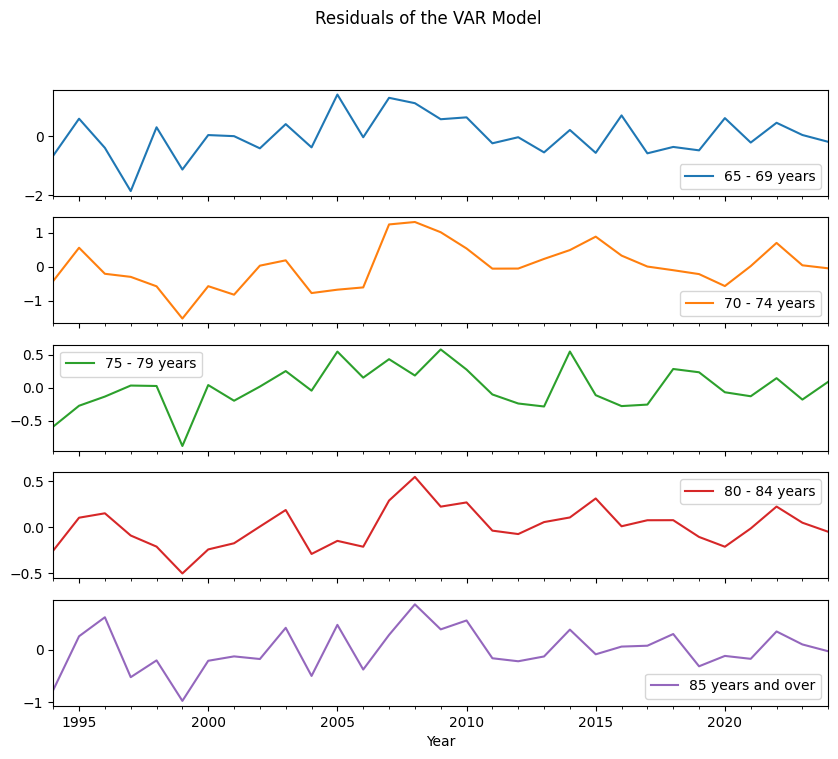

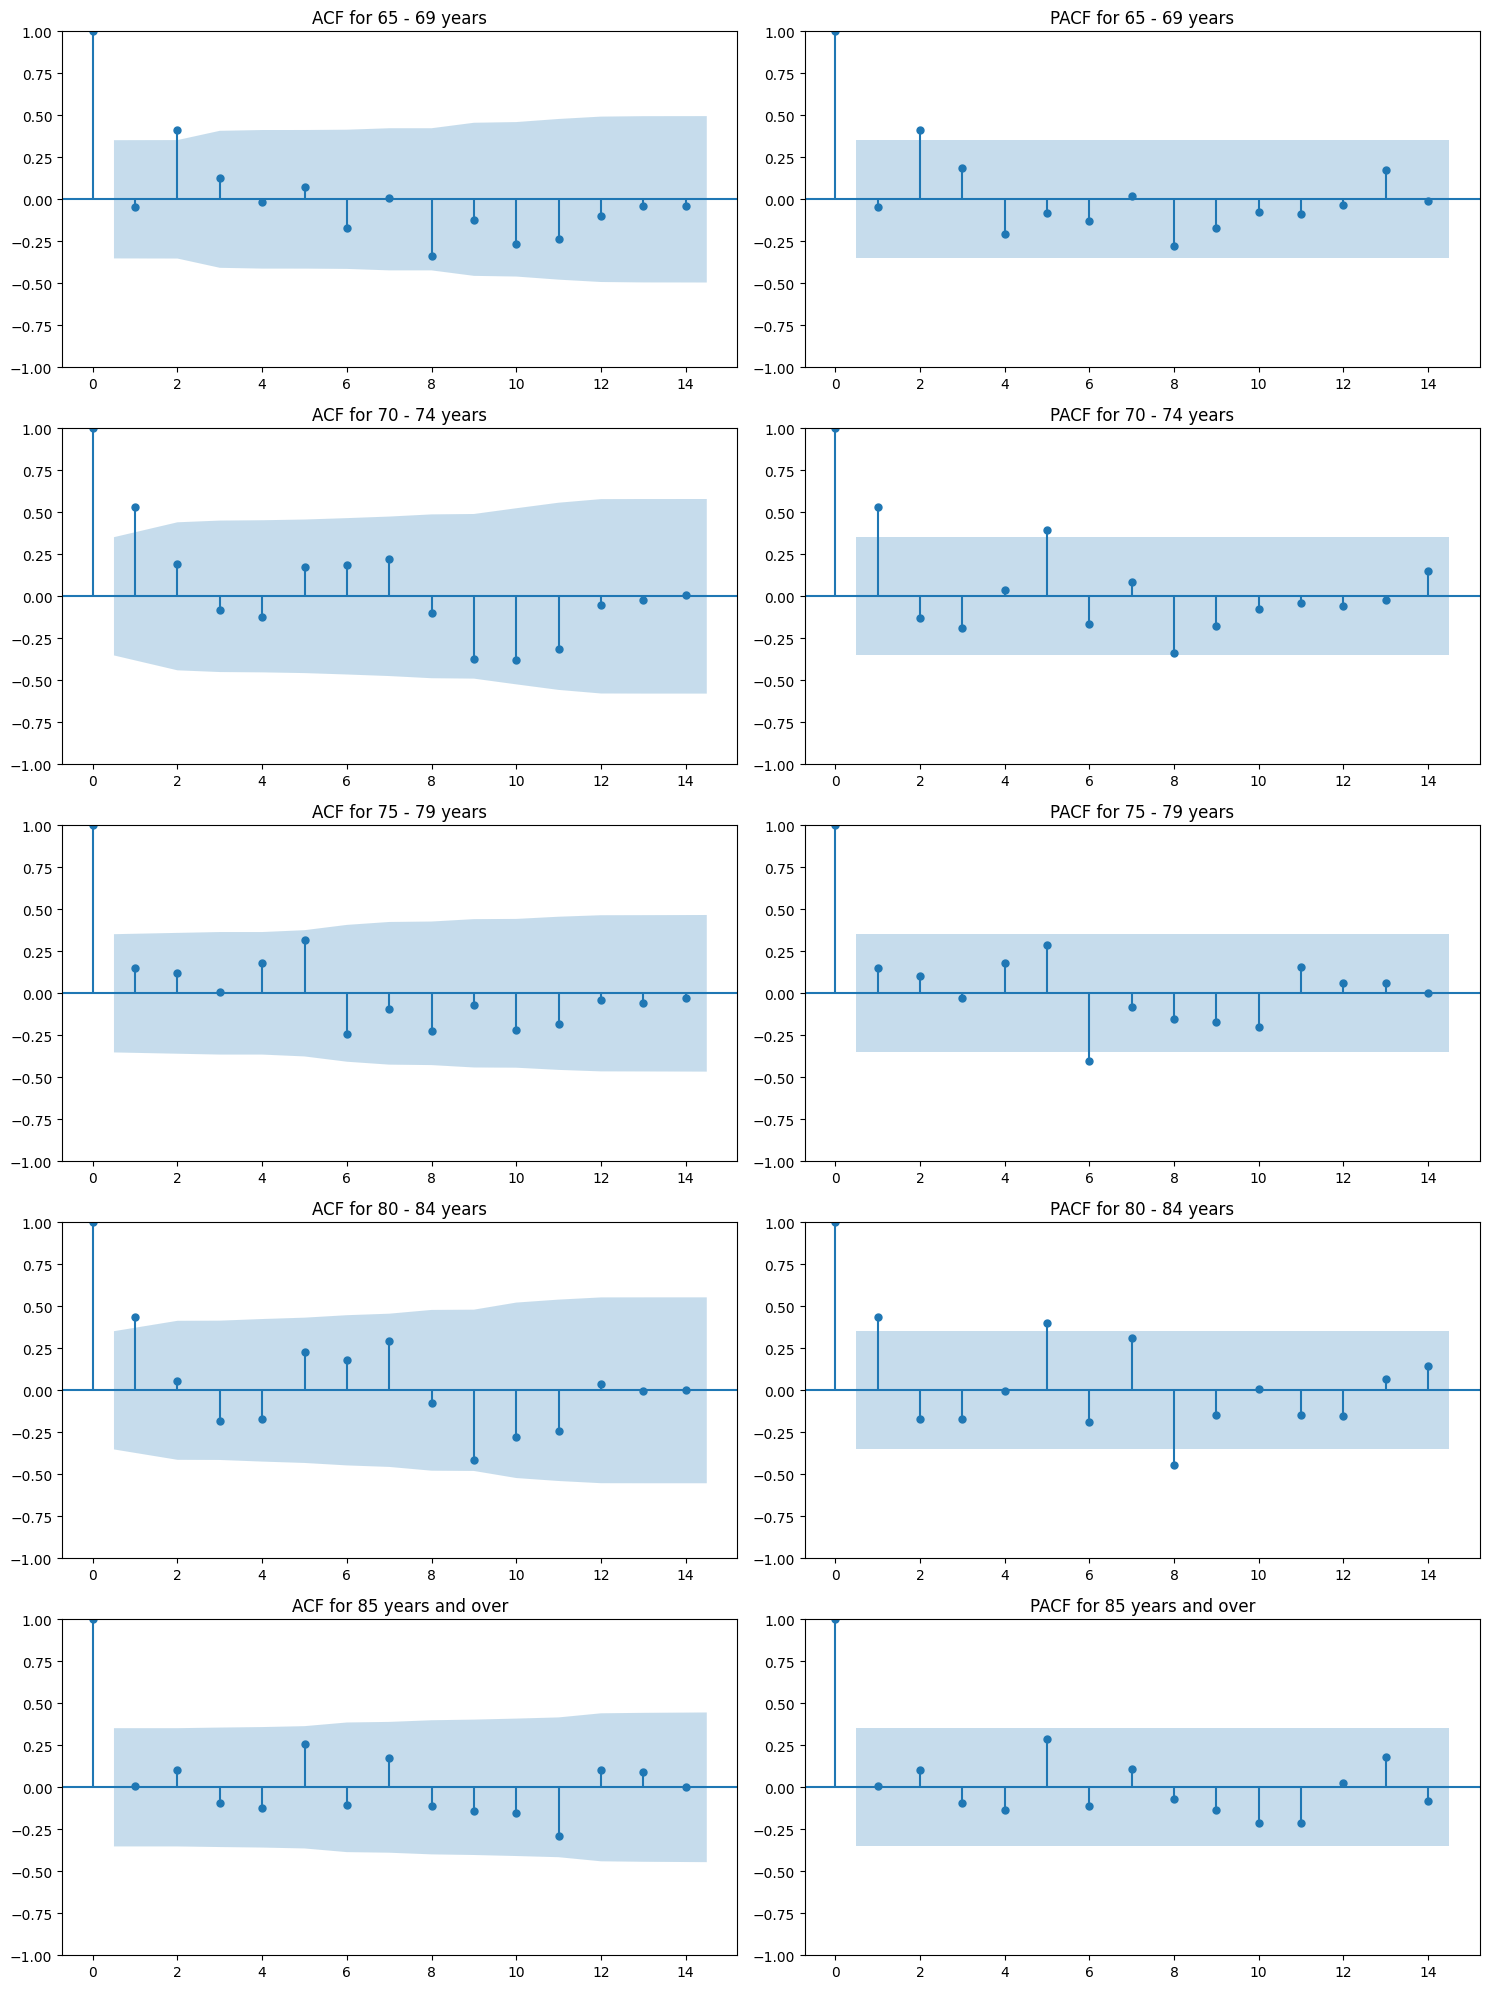

In [11]:
residuals = var_fitted.resid

residuals.plot(subplots=True, figsize=(10, 8), title="Residuals of the VAR Model")
plt.show()

fig, axes = plt.subplots(len(residuals.columns), 2, figsize=(15, 20))
axes = axes.flatten()

for i, column in enumerate(residuals.columns):
    lags = min(40, len(residuals[column]) // 2 - 1)

    ax_acf = axes[i * 2]
    plot_acf(residuals[column], lags=lags, ax=ax_acf)
    ax_acf.set_title(f'ACF for {column}')

    ax_pacf = axes[i * 2 + 1]
    plot_pacf(residuals[column], lags=lags, ax=ax_pacf)
    ax_pacf.set_title(f'PACF for {column}')

plt.tight_layout()
plt.show()

65 - 69 years        RMSE: 115.3729 MAPE: 61.0572%
70 - 74 years        RMSE: 95.9253 MAPE: 77.6568%
75 - 79 years        RMSE: 63.1910 MAPE: 52.0952%
80 - 84 years        RMSE: 31.3201 MAPE: 40.1076%
85 years and over    RMSE: 29.8842 MAPE: 47.9588%
Average RMSE: 29.8842 Average MAPE: 47.9588%


C:\Users\bayan\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


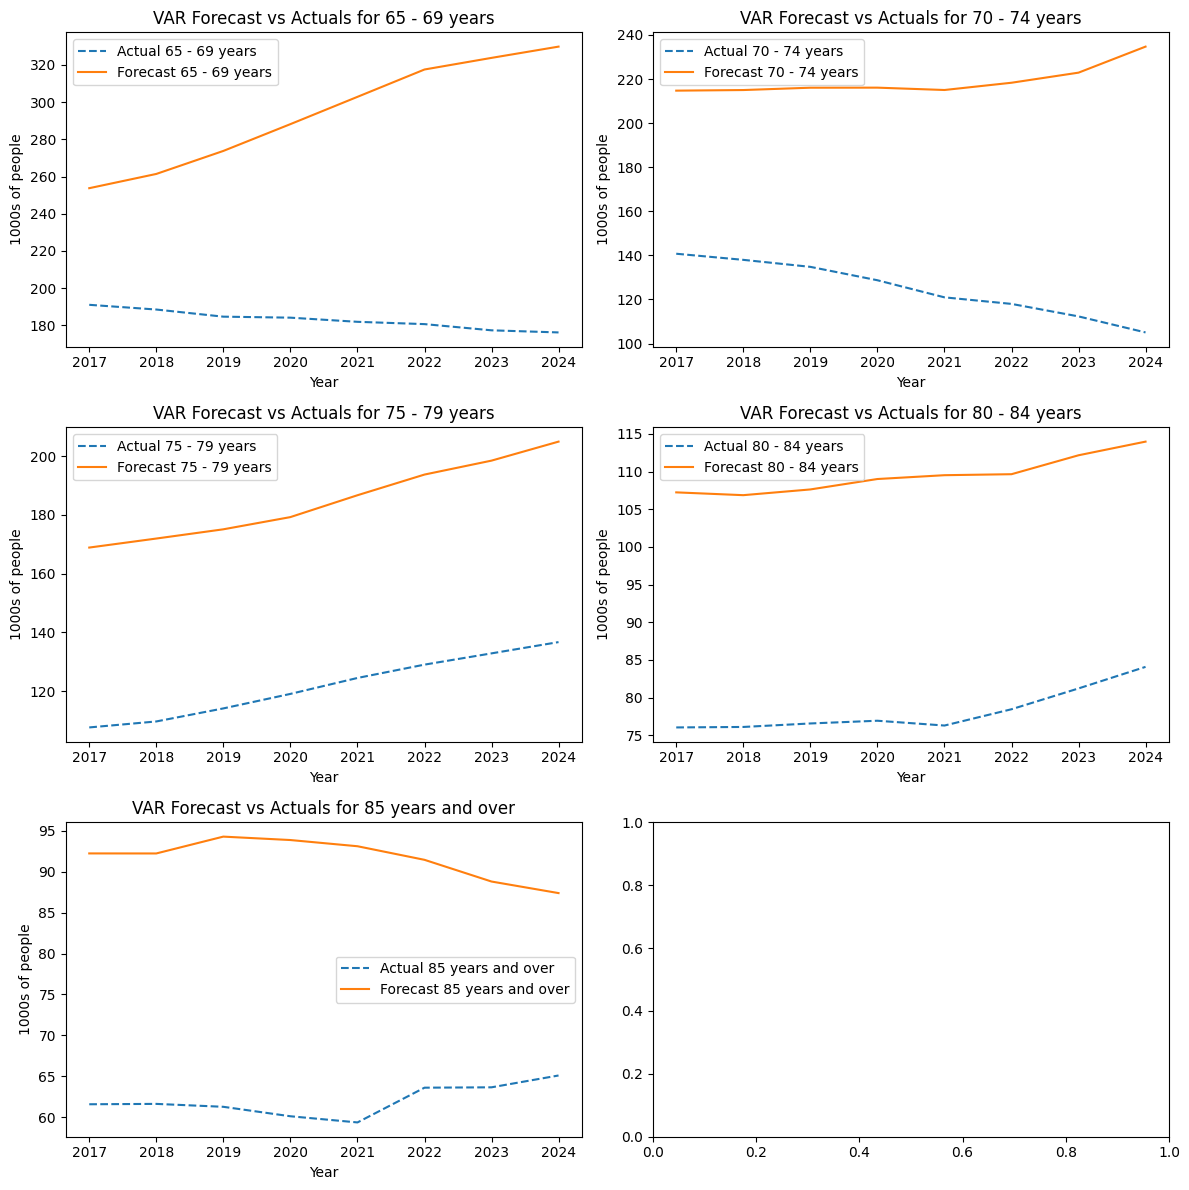

In [12]:
# Evaluation
train_size = int(len(df_selected) * 0.8)
train_data, test_data = df_selected[:train_size], df_selected[train_size:]

model_train = VAR(train_data)
lag_order_train = optimal_lag
var_fitted_train = model_train.fit(lag_order_train)

forecast_steps = len(test_data)
forecast = var_fitted_train.forecast(train_data.values[-lag_order_train:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=test_data.columns)

# Undoing second-order differencing for the forecast data
forecast_df_first_cumsum = forecast_df.cumsum()  # First cumsum to undo first-order differencing
forecast_df = forecast_df_first_cumsum.cumsum() + df_selected_copy.iloc[-1]  # Second cumsum to undo second-order differencing, and adding the last original value

# Undoing second-order differencing for the test data
test_data_first_cumsum = test_data.cumsum()  # First cumsum to undo first-order differencing
test_data = test_data_first_cumsum.cumsum() + df_selected_copy.iloc[:train_size].iloc[-1]  # Second cumsum to undo second-order differencing, adding the last original value from training set

rmses = []
mapes = []
for column in test_data.columns:
    rmse = metrics.root_mean_squared_error(test_data[column], forecast_df[column])
    mape = metrics.mean_absolute_percentage_error(test_data[column], forecast_df[column]) * 100
    print(f'{column:20} RMSE: {rmse:.4f} MAPE: {mape:.4f}%')
    rmses.append(rmse)
    mapes.append(mape)
    
print(f'Average RMSE: {np.mean(rmse):.4f} Average MAPE: {np.mean(mape):.4f}%')
    
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()
for idx, column in enumerate(selected_columns):
    ax = axes[idx]
    ax.plot(test_data.index, test_data[column], label=f"Actual {column}", linestyle='--')
    ax.plot(forecast_df.index, forecast_df[column], label=f"Forecast {column}")

    ax.set_xlabel('Year')
    ax.set_ylabel('1000s of people')
    ax.legend()
    ax.set_title(f'VAR Forecast vs Actuals for {column}')
plt.tight_layout()
plt.show()

C:\Users\bayan\AppData\Local\Temp\ipykernel_29524\463262669.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=combined_df.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='Y'), columns=df_selected.columns)


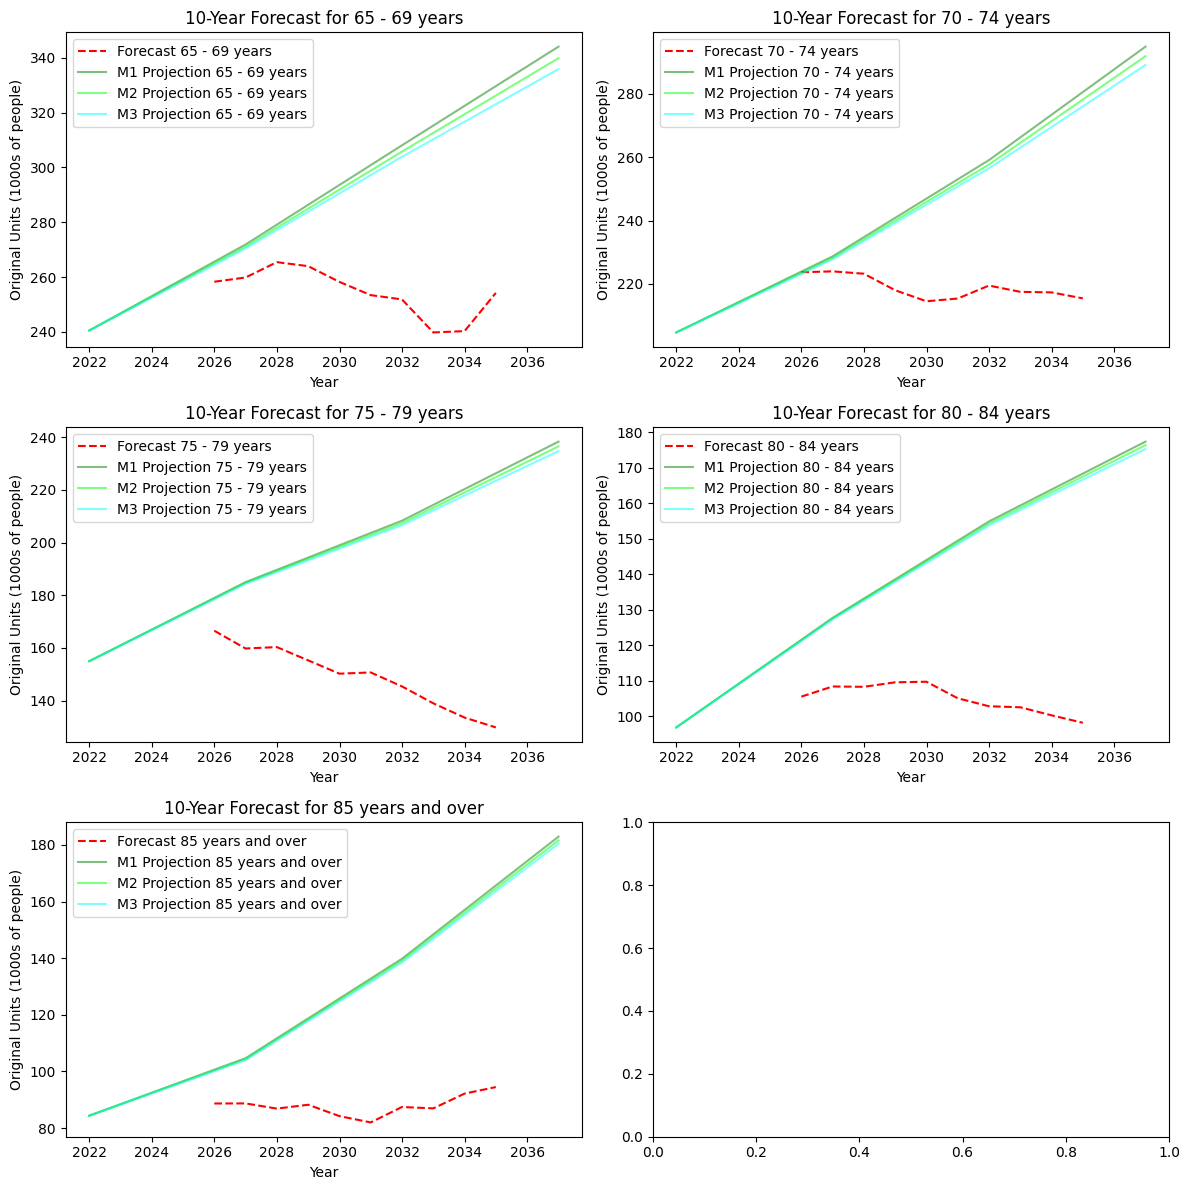

In [13]:
# Forecasting

forecast_steps = 10
last_data = df_selected.iloc[-lag_order_train:]

forecast = var_fitted_train.forecast(last_data.values, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=combined_df.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='Y'), columns=df_selected.columns)

# Reversing the differencing
forecast_first_cumsum = forecast_df.cumsum()
forecast_original_units = forecast_first_cumsum.cumsum() + df_selected_copy.iloc[-1]

# Projections from CSO
df_projections = pd.read_csv('../data/PEC23-ProjectedPopByAgeGroup.csv', index_col='Year')
df_projections.drop(columns=['Statistic', 'UNIT'], inplace=True)
df_projections.index = pd.to_datetime(df_projections.index, format='%Y')
projections_m1 = df_projections[df_projections['Criteria for Projection'] == 'Method - M1']
projections_m2 = df_projections[df_projections['Criteria for Projection'] == 'Method - M2']
projections_m3 = df_projections[df_projections['Criteria for Projection'] == 'Method - M3']

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()
for idx, column in enumerate(selected_columns):
    ax = axes[idx]
    ax.plot(forecast_original_units.index, forecast_original_units[column], label=f"Forecast {column}", linestyle='--', color='red')
    ax.plot(projections_m1[column][:-4].index, projections_m1[column][:-4], label=f'M1 Projection {column}', color='green', alpha=0.5)
    ax.plot(projections_m2[column][:-4].index, projections_m2[column][:-4], label=f'M2 Projection {column}', color='lime', alpha=0.5)
    ax.plot(projections_m3[column][:-4].index, projections_m3[column][:-4], label=f'M3 Projection {column}', color='cyan', alpha=0.5)

    ax.set_xlabel('Year')
    ax.set_ylabel('Original Units (1000s of people)')
    ax.set_title(f'10-Year Forecast for {column}')
    ax.legend()
    
plt.tight_layout()
plt.show()